 # Importa bibliotecas

In [1]:
import pandas as pd
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Dense, Masking, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import datetime
import pickle
import os
import random
import tensorflow as tf


2025-09-02 12:55:11.055230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756828511.143335    1300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756828511.170628    1300 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756828511.347273    1300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756828511.347306    1300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756828511.347308    1300 computation_placer.cc:177] computation placer alr

 ## Definições

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


 # Funções

In [3]:
def save_history(history, timestamp):
    with open(f'training_history/pkl/{timestamp}.pkl', 'wb') as f:
        pickle.dump(history.history, f)


 # Preparando dados

In [4]:
csv_files = glob.glob('/mnt/d/dados_surdos/CSVs/dados_pessoa2_*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df


,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,repetition,frame,word
0,-0.015607,-0.012011,0.085424,0.002198,0.002056,0.062723,0.006184,0.013907,0.043209,0.012581,...,0.010308,-0.014324,0.022577,0.024143,-0.012121,0.028077,0.045234,0,0,amanda
1,-0.026881,-0.016575,0.088360,-0.004162,0.000434,0.064802,-0.002506,0.012053,0.047482,0.012059,...,0.006520,-0.015839,0.031193,0.016019,-0.011932,0.045492,0.040148,0,1,amanda
2,-0.035663,-0.030682,0.055793,-0.007602,-0.020255,0.040326,0.010573,-0.015109,0.029176,0.034369,...,0.005534,-0.019610,0.026664,0.005605,-0.010181,0.035500,0.006776,0,2,amanda
3,-0.019877,-0.012865,0.072611,-0.000591,-0.004493,0.054639,0.013915,0.000713,0.042367,0.027604,...,-0.000779,-0.025155,0.012071,-0.001725,-0.019246,0.009204,0.004844,0,3,amanda
4,-0.017428,0.004787,0.097933,0.009870,0.017381,0.064847,0.028842,0.017987,0.040486,0.040202,...,0.009571,-0.020957,0.031525,0.010485,-0.019979,0.045894,0.023430,0,4,amanda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.006988,0.059106,0.065497,0.018958,0.042008,0.045603,0.036582,0.031468,0.027750,0.041668,...,0.002797,-0.024219,-0.000852,0.008091,-0.022274,0.007363,0.013810,9,147,zimbabwe
32557,-0.009849,0.055787,0.067987,0.014397,0.041232,0.047113,0.037282,0.032145,0.029211,0.048260,...,-0.007995,-0.022478,0.014994,-0.003822,-0.018179,0.023010,0.001642,9,148,zimbabwe
32558,-0.010559,0.020268,0.080483,0.017107,0.022272,0.055852,0.036796,0.022708,0.033825,0.051180,...,0.001762,-0.009830,0.034790,0.009860,-0.008334,0.042102,0.022468,9,149,zimbabwe
32559,-0.009250,-0.018638,0.095681,0.017051,-0.004999,0.066634,0.035379,0.004927,0.049955,0.049636,...,0.011627,-0.027174,0.028498,0.016777,-0.027771,0.039360,0.024744,9,150,zimbabwe


In [5]:
# Normaliza features com valores entre 0 e 1
scaler = MinMaxScaler()
landmark_cols = list(df.columns[:63])
df[landmark_cols] = scaler.fit_transform(df[landmark_cols])


In [6]:
# Separa features e labels por vídeo
grouped = df.groupby(['word', 'repetition'])
X_raw = []
y_raw = []

for (word, rep), group in grouped:
    sequence = group[landmark_cols].values
    X_raw.append(sequence)
    y_raw.append(word)


 # KFold Cross Validation

In [7]:
max_len = max(len(seq) for seq in X_raw)
N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
all_fold_accuracies = []
all_fold_losses = []
histories = []

for fold, (train_index, val_index) in enumerate(kf.split(X_raw), 1):
    print(f"\n========== FOLD {fold} ==========")

    X_train_raw = [X_raw[i] for i in train_index]
    y_train_raw = [y_raw[i] for i in train_index]
    X_val_raw   = [X_raw[i] for i in val_index]
    y_val_raw   = [y_raw[i] for i in val_index]

    X_train = pad_sequences(X_train_raw, maxlen=max_len, padding='post', dtype='float32')
    X_val   = pad_sequences(X_val_raw,   maxlen=max_len, padding='post', dtype='float32')

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)

    num_classes = len(label_encoder.classes_)

    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_len, 63)))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    checkpoint_filepath = f'models/fold_{fold}_checkpoint.model.keras'

    early_stop = EarlyStopping(patience=30, restore_best_weights=True)
    csv_logger = CSVLogger(f'training_log_fold_{fold}.csv')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001, verbose=1)
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=1000,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[csv_logger, reduce_lr, model_checkpoint_callback]
    )

    histories.append(history)

    best_model = load_model(checkpoint_filepath)
    val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
    print(f"FOLD {fold} - Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

    all_fold_accuracies.append(val_accuracy)
    all_fold_losses.append(val_loss)



========== FOLD 1 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-09-02 12:55:18.160052: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-09-02 12:55:18.397292: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.0424 - loss: 3.5156 - val_accuracy: 0.0385 - val_loss: 3.3235 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0407 - loss: 3.3852 - val_accuracy: 0.0000e+00 - val_loss: 3.2771 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0334 - loss: 3.3542 - val_accuracy: 0.0769 - val_loss: 3.2575 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0732 - loss: 3.2182 - val_accuracy: 0.0385 - val_loss: 3.1671 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0729 - loss: 3.1602 - val_accuracy: 0.0385 - val_loss: 3.0759 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0811 - loss: 3.0924 - val_accuracy: 0.1154 - val_loss: 3.1206 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0776 - loss: 3.0456 - va

2025-09-02 13:06:32.578720: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 1 - Accuracy: 0.6154, Loss: 1.4361

========== FOLD 2 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.0486 - loss: 3.5120 - val_accuracy: 0.0000e+00 - val_loss: 3.2854 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0759 - loss: 3.2730 - val_accuracy: 0.0000e+00 - val_loss: 3.2719 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0470 - loss: 3.1907 - val_accuracy: 0.1538 - val_loss: 3.0611 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1388 - loss: 2.9796 - val_accuracy: 0.0769 - val_loss: 2.9146 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1490 - loss: 2.9429 - val_accuracy: 0.1154 - val_loss: 2.9847 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2699 - loss: 2.7641 - val_accuracy: 0.2308 - val_loss: 2.6372 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2725 - loss: 2.5293 

2025-09-02 13:18:30.350684: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 2 - Accuracy: 0.6923, Loss: 1.0198

========== FOLD 3 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.0158 - loss: 3.4649 - val_accuracy: 0.0385 - val_loss: 3.4572 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0579 - loss: 3.3690 - val_accuracy: 0.0000e+00 - val_loss: 3.3189 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1188 - loss: 3.1848 - val_accuracy: 0.0769 - val_loss: 3.2458 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0948 - loss: 2.9881 - val_accuracy: 0.0769 - val_loss: 3.1151 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1157 - loss: 2.9245 - val_accuracy: 0.0769 - val_loss: 3.0540 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1138 - loss: 2.8321 - val_accuracy: 0.1538 - val_loss: 2.9097 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1862 - loss: 2.7138 - va

2025-09-02 13:30:38.967045: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 3 - Accuracy: 0.8846, Loss: 0.4923

========== FOLD 4 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.0196 - loss: 3.3867 - val_accuracy: 0.0385 - val_loss: 3.3366 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0282 - loss: 3.3100 - val_accuracy: 0.1538 - val_loss: 3.2304 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1088 - loss: 3.1996 - val_accuracy: 0.1154 - val_loss: 3.1772 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0842 - loss: 3.0661 - val_accuracy: 0.1538 - val_loss: 2.9861 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1647 - loss: 2.9104 - val_accuracy: 0.1154 - val_loss: 3.0062 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1407 - loss: 2.8392 - val_accuracy: 0.1923 - val_loss: 2.8029 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1286 - loss: 2.6930 - val_ac

2025-09-02 13:42:24.543438: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 4 - Accuracy: 0.7692, Loss: 1.0825

========== FOLD 5 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0583 - loss: 3.5251 - val_accuracy: 0.0000e+00 - val_loss: 3.4205 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0827 - loss: 3.2973 - val_accuracy: 0.0385 - val_loss: 3.3487 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1211 - loss: 3.0746 - val_accuracy: 0.0385 - val_loss: 3.1731 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1449 - loss: 2.9263 - val_accuracy: 0.0000e+00 - val_loss: 3.0810 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1427 - loss: 2.8247 - val_accuracy: 0.0385 - val_loss: 2.9297 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1522 - loss: 2.6792 - val_accuracy: 0.0385 - val_loss: 2.9692 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1674 - loss: 2.6803 

2025-09-02 13:54:22.677115: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 5 - Accuracy: 0.5385, Loss: 1.5101

========== FOLD 6 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.0519 - loss: 3.5977 - val_accuracy: 0.1154 - val_loss: 3.2374 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0711 - loss: 3.2957 - val_accuracy: 0.1154 - val_loss: 3.1718 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0828 - loss: 3.1602 - val_accuracy: 0.1154 - val_loss: 3.0020 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0951 - loss: 2.9451 - val_accuracy: 0.0769 - val_loss: 2.8706 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1768 - loss: 2.7165 - val_accuracy: 0.1923 - val_loss: 2.6082 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1444 - loss: 2.6314 - val_accuracy: 0.1923 - val_loss: 2.5820 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1597 - loss: 2.4915 - val_ac

2025-09-02 14:06:16.780115: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 6 - Accuracy: 0.7308, Loss: 1.3276

========== FOLD 7 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0575 - loss: 3.5019 - val_accuracy: 0.0000e+00 - val_loss: 3.5373 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0578 - loss: 3.2528 - val_accuracy: 0.0385 - val_loss: 3.3828 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1019 - loss: 3.2425 - val_accuracy: 0.0385 - val_loss: 3.1964 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0758 - loss: 3.1527 - val_accuracy: 0.1154 - val_loss: 3.0241 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1230 - loss: 2.9952 - val_accuracy: 0.1923 - val_loss: 2.8280 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1663 - loss: 2.8420 - val_accuracy: 0.2308 - val_loss: 2.6946 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2359 - loss: 2.5885 - va

2025-09-02 14:17:37.738991: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 7 - Accuracy: 0.5000, Loss: 1.2041

========== FOLD 8 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.0242 - loss: 3.4650 - val_accuracy: 0.0385 - val_loss: 3.4631 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0599 - loss: 3.3005 - val_accuracy: 0.0385 - val_loss: 3.2778 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0421 - loss: 3.2729 - val_accuracy: 0.1923 - val_loss: 3.1137 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1330 - loss: 3.0486 - val_accuracy: 0.1538 - val_loss: 2.9722 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1181 - loss: 2.9212 - val_accuracy: 0.1923 - val_loss: 2.8419 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1176 - loss: 2.7392 - val_accuracy: 0.1538 - val_loss: 2.5268 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1633 - loss: 2.6403 - val_ac

2025-09-02 14:28:55.574641: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 8 - Accuracy: 0.5000, Loss: 1.3722

========== FOLD 9 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0482 - loss: 3.5032 - val_accuracy: 0.1154 - val_loss: 3.2598 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0373 - loss: 3.3188 - val_accuracy: 0.0385 - val_loss: 3.3735 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0970 - loss: 3.1265 - val_accuracy: 0.1154 - val_loss: 3.2381 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1333 - loss: 3.0102 - val_accuracy: 0.1923 - val_loss: 3.1122 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1479 - loss: 2.8841 - val_accuracy: 0.0385 - val_loss: 3.0967 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1969 - loss: 2.7373 - val_accuracy: 0.0769 - val_loss: 2.9029 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1564 - loss: 2.

2025-09-02 14:40:52.967462: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 9 - Accuracy: 0.4231, Loss: 1.4536

========== FOLD 10 ==========
Epoch 1/1000


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.0518 - loss: 3.4048 - val_accuracy: 0.0385 - val_loss: 3.4151 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0661 - loss: 3.3647 - val_accuracy: 0.0385 - val_loss: 3.3173 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1275 - loss: 3.1139 - val_accuracy: 0.0769 - val_loss: 3.2450 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0863 - loss: 3.1400 - val_accuracy: 0.1154 - val_loss: 3.1453 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1868 - loss: 2.8808 - val_accuracy: 0.0769 - val_loss: 2.9500 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2099 - loss: 2.6524 - val_accuracy: 0.1154 - val_loss: 2.7898 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2760 - loss: 2.4292 - val_ac

2025-09-02 14:52:14.597492: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 10 - Accuracy: 0.6538, Loss: 1.0937


In [8]:
print("\n========== RESULTADOS FINAIS ==========")
for i, (acc, loss) in enumerate(zip(all_fold_accuracies, all_fold_losses), 1):
    print(f"Fold {i}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")
print(f"Média de acurácia: {np.mean(all_fold_accuracies):.4f}")


========== RESULTADOS FINAIS ==========
Fold 1: Accuracy = 0.6154, Loss = 1.4361
Fold 2: Accuracy = 0.6923, Loss = 1.0198
Fold 3: Accuracy = 0.8846, Loss = 0.4923
Fold 4: Accuracy = 0.7692, Loss = 1.0825
Fold 5: Accuracy = 0.5385, Loss = 1.5101
Fold 6: Accuracy = 0.7308, Loss = 1.3276
Fold 7: Accuracy = 0.5000, Loss = 1.2041
Fold 8: Accuracy = 0.5000, Loss = 1.3722
Fold 9: Accuracy = 0.4231, Loss = 1.4536
Fold 10: Accuracy = 0.6538, Loss = 1.0937
Média de acurácia: 0.6308


 # Gráficos de Acurácia e Loss por Fold

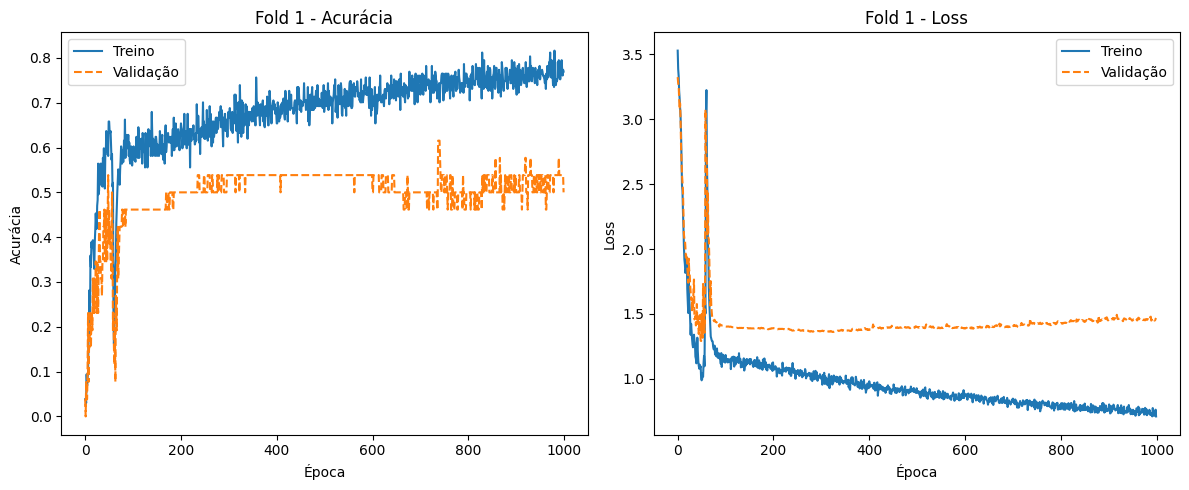

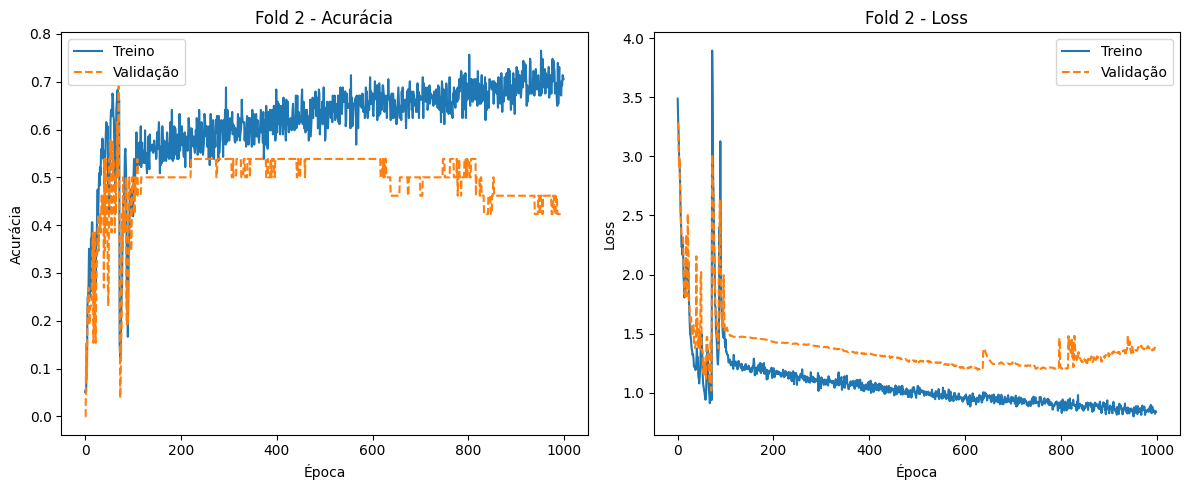

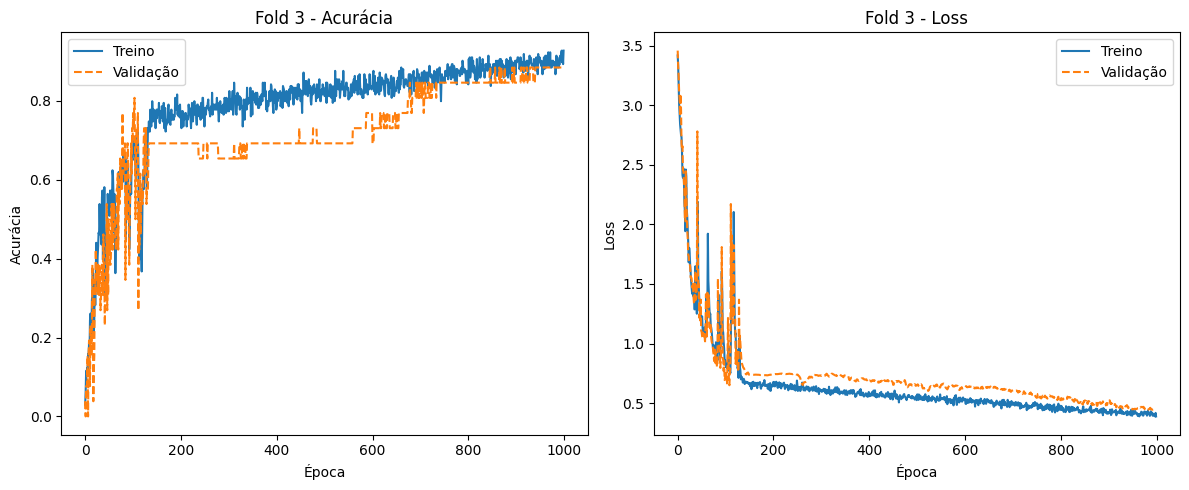

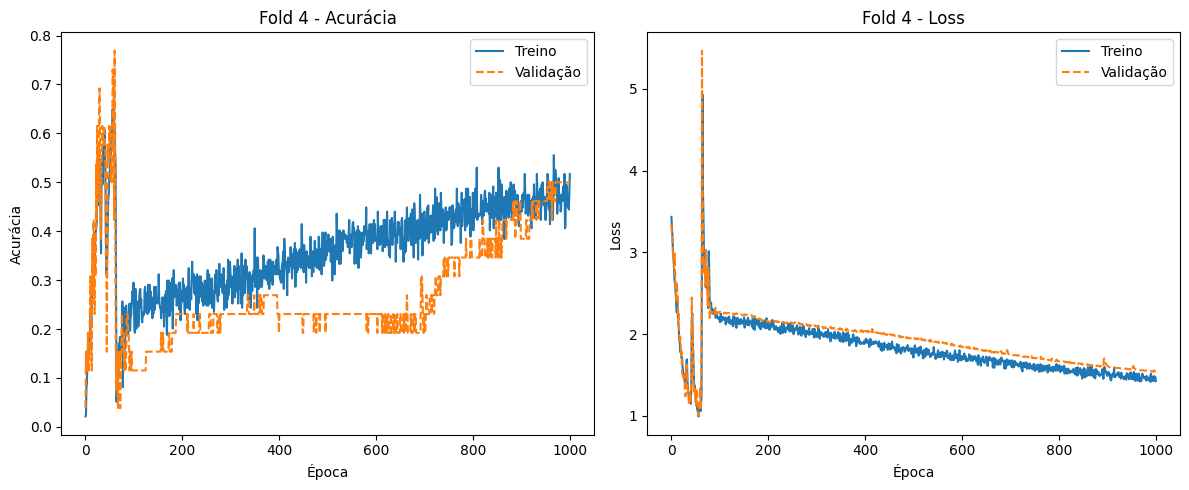

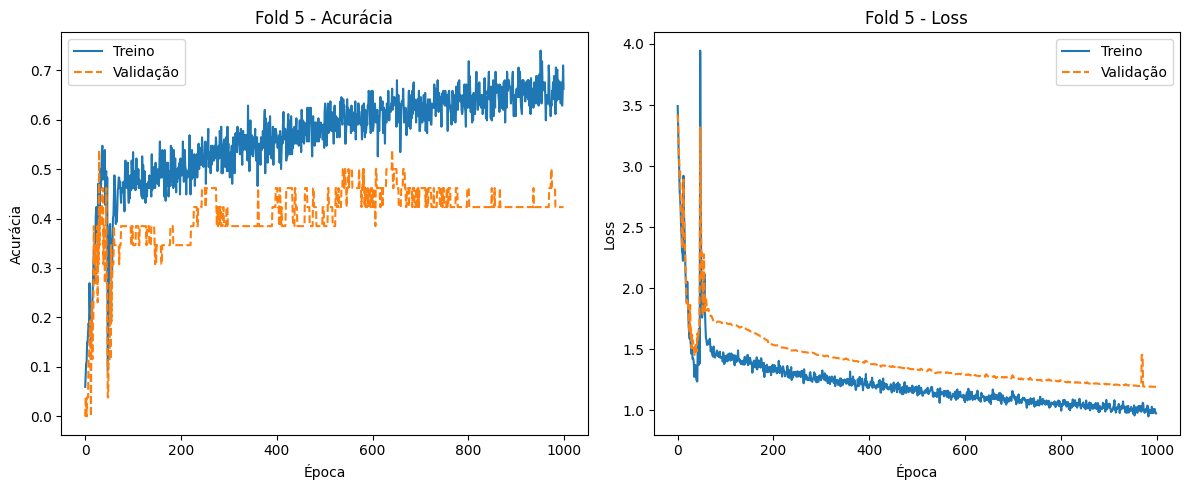

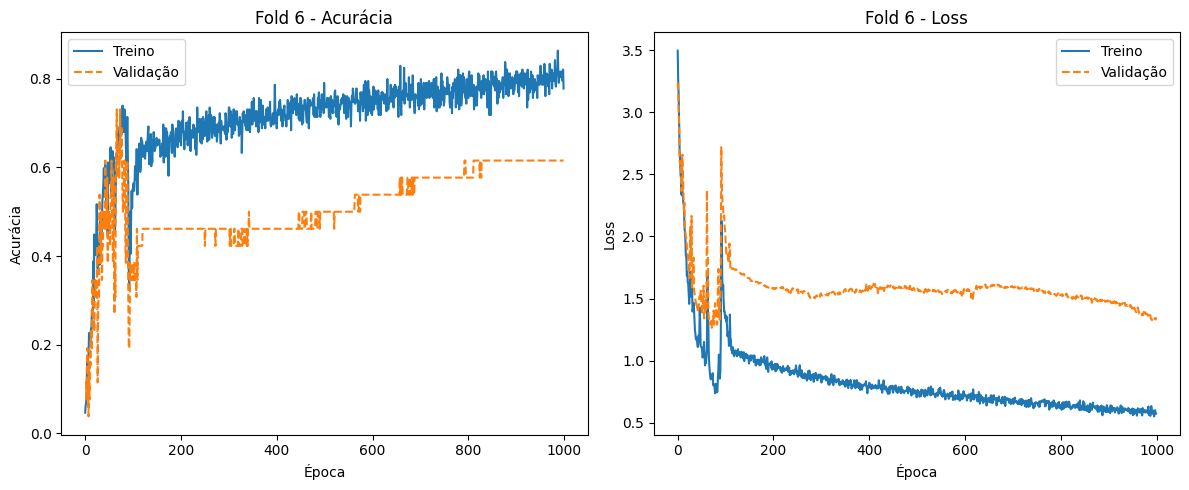

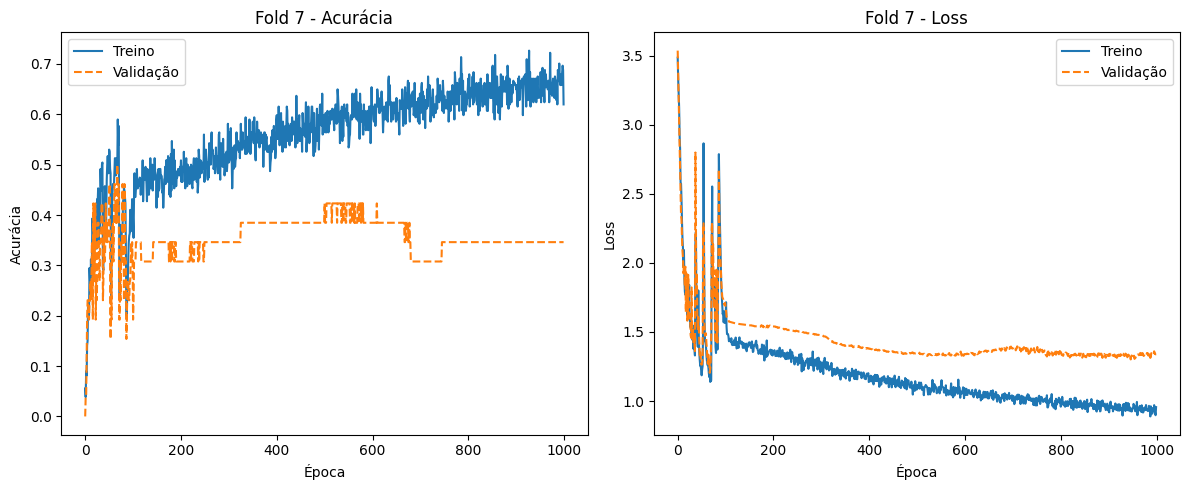

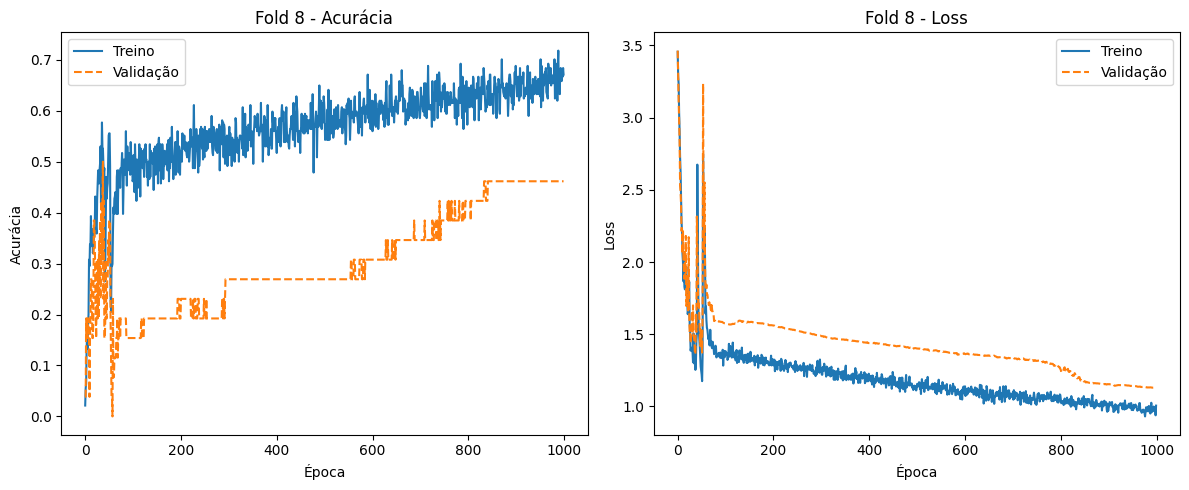

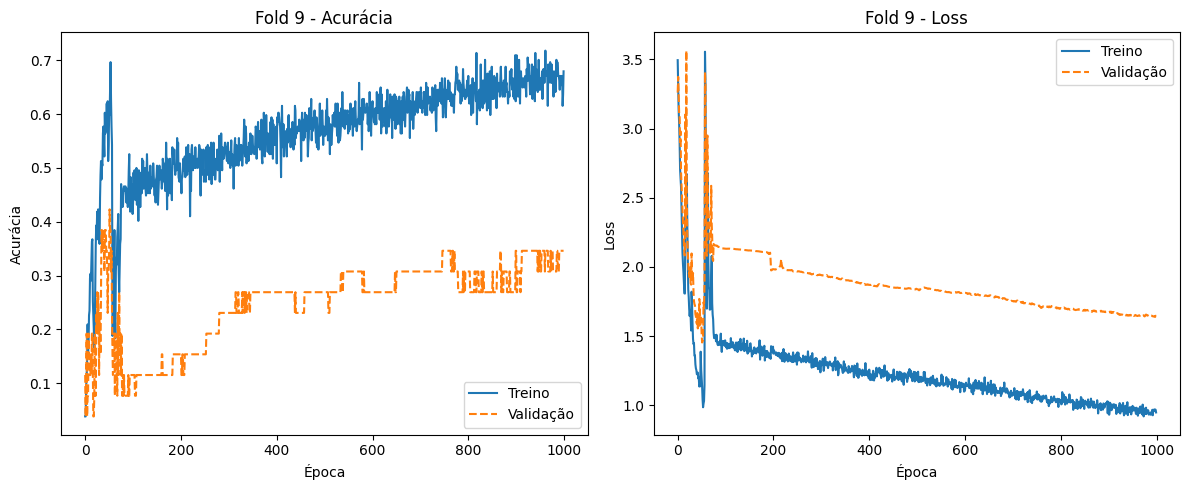

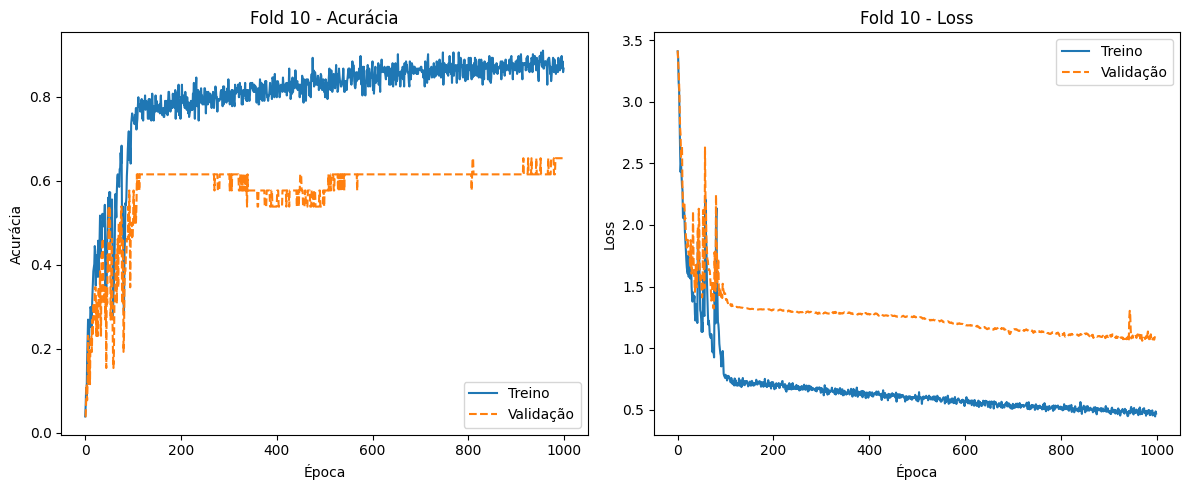

In [9]:
for i, history in enumerate(histories, 1):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

